Zieht sich die Parameterwerte aller Durchläufe in einen pandas dataframe

In [78]:
import pandas as pd
import glob

path =r'./testdata' # use your path
allFiles = glob.glob(path + "/*.txt")
frame = pd.DataFrame()

#will be converted to dataframe
list_ = []

#dict of style index in frame : (filename, index in file)
findfile = {}

#index for rows in frame
curr_row = 0
for file_ in allFiles:
    orig_ind = 0
    n = 3
    num_lines = sum(1 for l in open(file_))
    skip_idx = [x for x in range(1, num_lines) if x % n != 0]
    df = pd.read_csv(file_,index_col=None, skiprows=skip_idx, header = None)
    list_.append(df)
    for i in range(curr_row, curr_row+len(df.index)):
        findfile[i] = (file_, orig_ind)
        orig_ind += 1
    curr_row +=len(df.index)
frame = pd.concat(list_, ignore_index=True)
print(frame)

               0            1            2                     3
0    Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 395000 
1    Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 349500 
2    Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 326500 
3    Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 218000 
4    Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 480000 
5    Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 278000 
6    Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 546000 
7    Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 230000 
8    Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 512500 
9    Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 323000 
10   Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 629000 
11   Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 244500 
12   Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 321000 
13   Nodes: 1600   Edges: 800   phi: 0.001   Iterations: 432500 
14   Nodes: 1600   Edges:

Funktion die für gegebenes NNodes, NEdges, phi den Index im Datenframe (der Parameterwerte) ausgibt

In [79]:
import re

def getIndex(NNodes, NEdges, phi):
    lines = []
    for j in range(frame.shape[0]): #all rows
        getstr = frame[0][j]
        if ([int(s) for s in getstr.split() if s.isdigit()][0] == NNodes):
            getstr = frame[1][j]
            if ([int(s) for s in getstr.split() if s.isdigit()][0] == NEdges):
                getstr = frame[2][j]
                if (float(re.findall("\d+\.\d+", getstr)[0]) == phi):
                    lines.append(j)
    return lines

Funktion die für gegebenen Index des Dataframes (der Parameterwerte) den Meinungsvektor (OporComp = 0) oder den Komponentenvektor (OporComp = 1) aus der jeweiligen Datei liest

In [80]:
#OporComp = 0 for OpinionVector, 1 for ConnectedComponents
def getVector(frameIndex, OporComp):
    filename = (findfile[frameIndex])[0]
    fileindex = (findfile[frameIndex])[1]
    fileline = (fileindex*3)+1
    OpinionVector = pd.read_csv(filename, skiprows = fileline+OporComp, nrows = 1, header=None, delim_whitespace = True)
    return OpinionVector

Funktion die für gegebenes NNodes, NEdges, phi einen Matplotlib subplot eines Plot der Größe x * y an index z erstellt

In [81]:
from collections import Counter
import matplotlib.pyplot as plt


#ComponentSizes dependent on Phi
def histogram(ithplot, axs, NNodes, phi):
    hist = [0] * (NNodes+1)
    lines = []
    lines = getIndex(NNodes, NNodes/2, phi)
    if (len(lines) == 0):
        print("No Dataset found for NNodes = %d, phi = %.3f" %(NNodes,  phi))
        return
    for i in range(len(lines)):
        compvec=[NNodes] #empty array
        compvec = getVector(lines[i],1) #getComponentsizevector
        compvec = compvec.values.tolist()[0] #get list from dataframe
        compdic = Counter(compvec) #get Dict of type (compent number) : size
        comps = list(compdic.values()) #get list of size values
        d = Counter(comps) #get Dict sizeofCompononent : appearance
        for siz, app in d.items():
            hist[siz] += app
        hist[:] = [float(x) / NNodes for x in hist]
    hist[:] = [float(x) / len(lines) for x in hist] #average over number of datasets
    #print(hist)
    #hist[:] = [float(x) / NNodes for x in hist] 
    axs = axs.flatten()
    axs[ithplot].loglog(hist, 'o')
    title = "Phi: " +str(float(phi)) + " averaged over " + str(len(lines))
    axs[ithplot].set_title(title)
    axs[ithplot].set_xlim(xmin=0, xmax=NNodes)
    axs[ithplot].set_ylim(ymin = 0.00001, ymax=1.1)

[0.0, 0.0003977509351560059, 5.379338478074046e-05, 2.0639461674960235e-05, 1.0631254640657044e-05, 1.0627736573792077e-05, 3.7523449713138586e-06, 2.5003918470769885e-06, 3.1269536135868075e-06, 6.257812503056529e-07, 6.261723635866165e-07, 4.882813454270735e-13, 1.2503908691406252e-06, 6.253908692934037e-07, 6.250002441407204e-07, 6.257812501529696e-07, 6.2578173828125e-07, 1.2503908694458963e-06, 6.25000000152588e-07, 2.441406250000373e-13, 9.542711079120635e-20, 6.250002441407204e-07, 6.250002444458008e-07, 6.250000000000956e-07, 1.5277874477207658e-16, 6.25e-07, 1.455192091271096e-32, 6.253908692932129e-07, 9.542707353830337e-20, 2.4414072042707357e-13, 3.9062500000000003e-10, 3.725291753653437e-26, 5.684341886080802e-39, 3.9086914062500005e-10, 9.54270362854004e-20, 4.882812499999999e-13, 6.25e-07, 1.3877793232213446e-48, 9.54270362854004e-20, 6.25390869140625e-07, 5.684341886080802e-39, 2.3297616280615332e-29, 6.25e-07, 2.2204460492503133e-45, 1.5258789062500002e-16, 3.388131789

[0.0, 0.0003977509351560059, 5.379338478074046e-05, 2.0639461674960235e-05, 1.0631254640657044e-05, 1.0627736573792077e-05, 3.7523449713138586e-06, 2.5003918470769885e-06, 3.1269536135868075e-06, 6.257812503056529e-07, 6.261723635866165e-07, 4.882813454270735e-13, 1.2503908691406252e-06, 6.253908692934037e-07, 6.250002441407204e-07, 6.257812501529696e-07, 6.2578173828125e-07, 1.2503908694458963e-06, 6.25000000152588e-07, 2.441406250000373e-13, 9.542711079120635e-20, 6.250002441407204e-07, 6.250002444458008e-07, 6.250000000000956e-07, 1.5277874477207658e-16, 6.25e-07, 1.455192091271096e-32, 6.253908692932129e-07, 9.542707353830337e-20, 2.4414072042707357e-13, 3.9062500000000003e-10, 3.725291753653437e-26, 5.684341886080802e-39, 3.9086914062500005e-10, 9.54270362854004e-20, 4.882812499999999e-13, 6.25e-07, 1.3877793232213446e-48, 9.54270362854004e-20, 6.25390869140625e-07, 5.684341886080802e-39, 2.3297616280615332e-29, 6.25e-07, 2.2204460492503133e-45, 1.5258789062500002e-16, 3.388131789

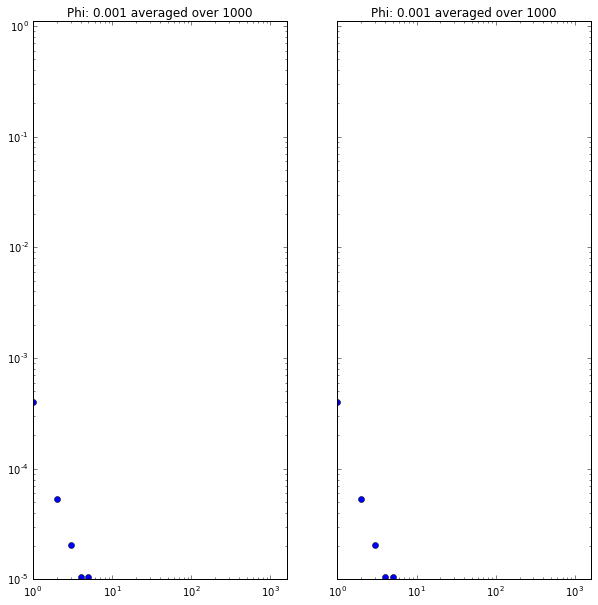

In [84]:
from math import ceil

NNodes = 1600
philist = [0.001, 0.001]
nplots = len(philist)
fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(10, 10))
for i, phi in enumerate(philist):
    histogram(i, axs, NNodes, phi)
    
#fig.title
#fig.savefig('./hist_') 
plt.show()

In [ ]:
def Manip_Results(NNodes, phi):
    hist = [0] * NNodes/10
    lines = []
    lines = getIndex(NNodes, 2*NNodes, phi)
    if (len(lines) == 0):
        print("No Dataset found for %d, %d, %.3f" %(NNodes, 2*NNodes, phi))
        return
    for i in range(len(lines)):
        compvec=[NNodes] #empty array
        compvec = getVector(lines[i],0) #getOpinionvector
        compvec = compvec.values.tolist()[0] #get list from dataframe
        compdic = Counter(compvec) #get Dict of type (opinion number) : size
        app = list(compdic.values())
        op = list(compdic.keys())
        for i in range(len(op)):
            hist[op[i]] += app[i] #add to histogram at position opinion(i) the number of nodes in the current graph that have this opinion
    hist[:] = [x / len(lines) for x in hist] #average over number of datasets
    axs = axs.flatten()
    axs[ithplot].plot(hist, 'o')
    return

from math import ceil

philist = [0.250, 0.999]
nplots = len(philist)
nrow = ceil(float(nplots/3))
fig, axs = plt.subplots(nrows=nrow, ncols=3, sharex='col', sharey='row', figsize=(10, 10))
for i, phi in enumerate(philist):
    print(phi)
    Manip_Results()
plt.show()